# SCHOOL SHOOTING FORECASTING
###Integrantes:  
Jose Saúl Vega  
Cristian Picón  
Diego Villamizar  
Oscar Sinuco  


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from google.colab import files
uploaded = files.upload()

# **DATASET PROVISTO POR KAGGLE.COM**
---

In [0]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data/pah_wikp_combo.csv')
#data = pd.read_csv('pah_wikp_combo.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index("Date",inplace=True)
data.head(20)

,City,State,AreaType,School,Fatalities,Wounded,Dupe,Source,Desc
Date,,,,,,,,,
1990-03-27,Brooklyn,New York,NaN,C,0,1.0,NaN,Wikp,A black youth was taunted with racial slurs by...
1990-05-20,Centerville,Tennessee,suburban,HS,1,NaN,NaN,Pah,NaN
1990-08-26,Las Vegas,Nevada,urban,HS,1,NaN,NaN,Pah,NaN
1990-09-11,San Antonio,Texas,NaN,HS,0,3.0,NaN,Wikp,3 students were wounded when gunfire broke out...
1991-01-08,Richardson,Texas,urban,HS,0,NaN,NaN,Pah,NaN
1991-02-06,Donna,Texas,NaN,HS,1,0.0,NaN,Wikp,15-year-old Raul Calvo shot himself dead while...
1991-04-23,Compton,California,urban,MS,1,NaN,True,Pah,NaN
1991-04-23,Compton,California,NaN,MS,1,0.0,NaN,Wikp,A teenager aimed and fired a handgun at a secu...
1991-09-18,Crosby,Texas,rural,HS,1,NaN,True,Pah,NaN


# **DATASET FILTRADO**
---

In [0]:
#Seleccionamos las columnas con las cuales vamos a trabajar.
data = data.iloc[:,[4]]
data = data[data.Fatalities != 0]
data.head(10)

,Fatalities
Date,
1990-05-20,1
1990-08-26,1
1991-02-06,1
1991-04-23,1
1991-04-23,1
1991-09-18,1
1991-09-18,1
1991-10-08,1
1991-11-01,5


# **ANÁLISIS DE DATOS**
---



*   **Comportamiento de los eventos desde 1990**






Text(0, 0.5, 'CANTIDAD')

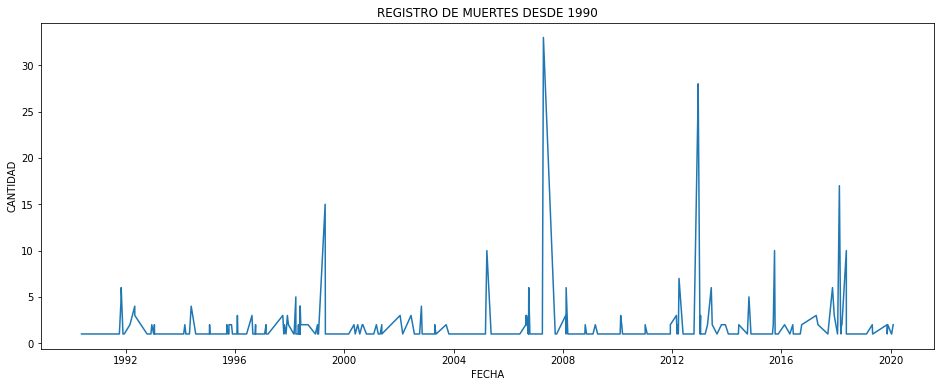

In [0]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(16,6))
plt.plot(data.index,data["Fatalities"])
plt.title("REGISTRO DE MUERTES DESDE 1990")
plt.xlabel("FECHA")
plt.ylabel("CANTIDAD")

Como se ve, se puede detallar cierta periodisidad en los eventos que ocurren en las escuelas.

*   **Comportamiento de los eventos por cada mes del año**


Text(0, 0.5, 'CANTIDAD')

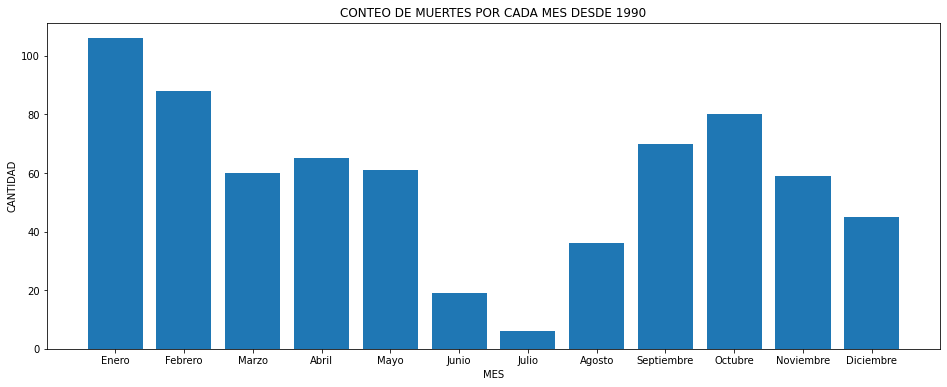

In [0]:
#CREO UNA COPIA DEL DATASET PARA NO BORRAR LO QUE HIZO OSCAR
#data2_copia =  pd.read_csv('pah_wikp_combo.csv').iloc[:,[0,1,4,5]]
data2_copia =  pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data/pah_wikp_combo.csv').iloc[:,[0,1,4,5]]
#CONVIERTO la columna Date a un formato válido Date para poder usar el .dt.month
data2_copia['Date'] = pd.to_datetime(data2_copia["Date"], format='%m/%d/%y')

#CUENTO LA CANTIDAD DE FATALITIES POR CADA MÉS
temp=data2_copia["Fatalities"].groupby(data2_copia["Date"].dt.month).count() #.plot(kind="bar")
figure(figsize=(16,6))

plt.bar(["Enero","Febrero","Marzo","Abril","Mayo","Junio","Julio","Agosto","Septiembre","Octubre","Noviembre","Diciembre"],temp.values)
plt.title("CONTEO DE MUERTES POR CADA MES DESDE 1990")
plt.xlabel("MES")
plt.ylabel("CANTIDAD")

Se ve que  a mitades del año la tasa se tiroteos baja significativamente 

**COMENZAMOS SA REALIZAR LOS PASOS DE ARIMA**

In [0]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

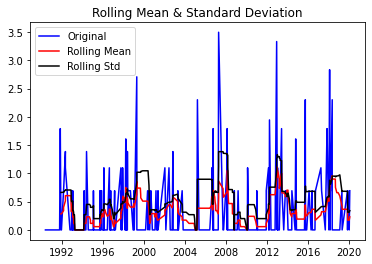

Results of Dickey-Fuller Test:
Test Statistic                -8.882058e+00
p-value                        1.309866e-14
#Lags Used                     3.000000e+00
Number of Observations Used    4.080000e+02
Critical Value (1%)           -3.446480e+00
Critical Value (5%)           -2.868650e+00
Critical Value (10%)          -2.570557e+00
dtype: float64


In [0]:
ts1 = data["Fatalities"]
test_stationarity(np.log(ts1))

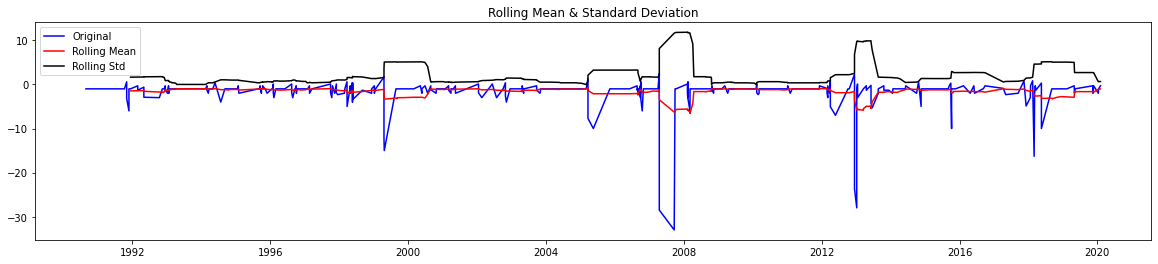

Results of Dickey-Fuller Test:
Test Statistic                -7.994488e+00
p-value                        2.424738e-12
#Lags Used                     5.000000e+00
Number of Observations Used    4.050000e+02
Critical Value (1%)           -3.446600e+00
Critical Value (5%)           -2.868703e+00
Critical Value (10%)          -2.570586e+00
dtype: float64


In [0]:
plt.figure(figsize=(20,4))
ts1_log_diff_shifting = np.log(ts1) - ts1.shift()
ts1_log_diff_shifting.dropna(inplace=True)
test_stationarity(ts1_log_diff_shifting)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


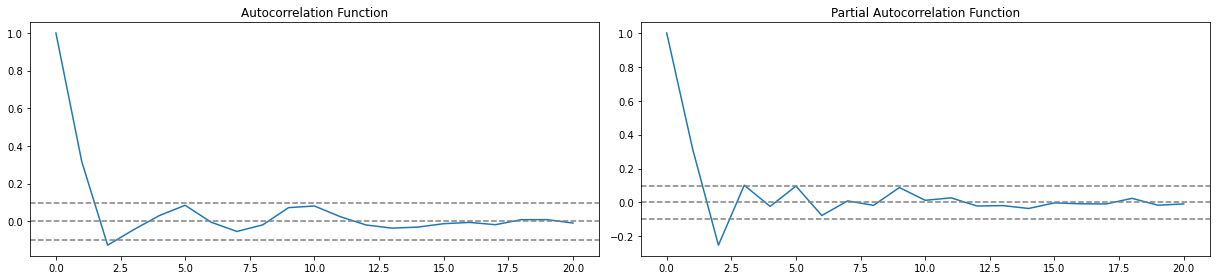

In [0]:
plt.figure(figsize=(17,4))
ACF = acf(ts1_log_diff_shifting, nlags=20)
PACF = pacf(ts1_log_diff_shifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(1,2,1)
plt.plot(ACF)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts1_log_diff_shifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts1_log_diff_shifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(1,2,2)
plt.plot(PACF)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts1_log_diff_shifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts1_log_diff_shifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout() 

In [0]:
#Funcion para encontrar q y p en graficas anteriores.
def cruce(funcion,tamaño):
  lim_sup=1.96/np.sqrt(tamaño)
  valor_q=None
  for i in range(len(funcion)):
    if(i<len(funcion)-1):
      if(funcion[i]>=lim_sup and funcion[i+1]<lim_sup ):
        valor_q=i+1
        break;
      if(funcion[i]<lim_sup and funcion[i+1]>=lim_sup ):
        valor_q=i+1
  return valor_q

In [0]:
valor_q=cruce(ACF,len(ts1))
valor_p=cruce(PACF,len(ts1))
print ("valor q = ",valor_q, "valor p = ",valor_p)

valor q =  2 valor p =  2


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Plotting AR model


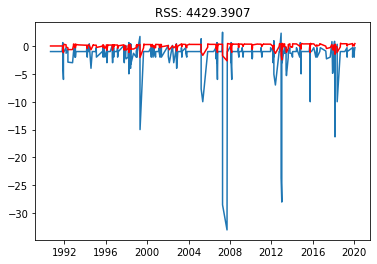

In [0]:
#Creamos el modelo y entrenamos con los datos de nuestro dataset.
model = ARIMA(np.log(ts1), order=(valor_q,1,valor_p))
results_ARIMA = model.fit(disp=-1)
plt.plot(ts1_log_diff_shifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - ts1_log_diff_shifting)**2))
print('Plotting AR model')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


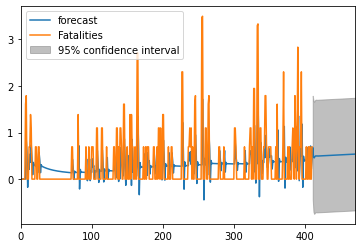

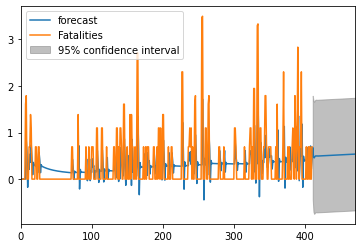

In [0]:
#Tenemos 412 dias y queremos predecir para los siguientes 60 dias
results_ARIMA.plot_predict(1,472) 

In [0]:
prediction = results_ARIMA.predict(1,472) 
print(prediction[412:440])

412   -0.180584
413   -0.041293
414    0.026110
415    0.015405
416   -0.000570
417   -0.002437
418    0.000252
419    0.001291
420    0.001018
421    0.000746
422    0.000731
423    0.000782
424    0.000797
425    0.000791
426    0.000786
427    0.000786
428    0.000787
429    0.000788
430    0.000787
431    0.000787
432    0.000787
433    0.000787
434    0.000787
435    0.000787
436    0.000787
437    0.000787
438    0.000787
439    0.000787
dtype: float64


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


**COMENZAMOS A APLICAR EXPONENTIAL SMOOTHING**

In [0]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data/pah_wikp_combo.csv')
#data['Date'] = pd.to_datetime(data['Date'])
data.set_index("Date",inplace=True)
data = data.iloc[:,[4]]
data = data[data.Fatalities != 0]

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


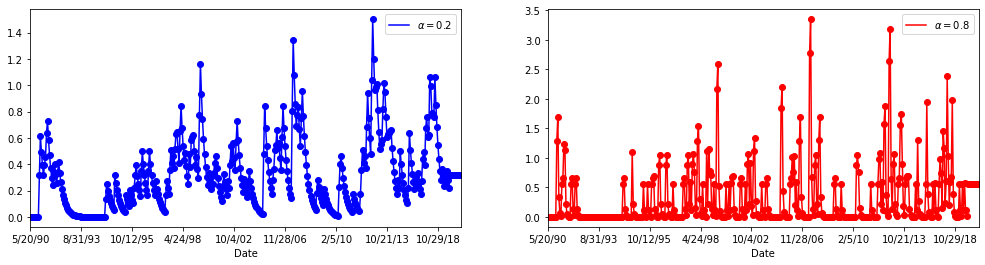

In [0]:
# # Simple Exponential Smoothing
plt.figure(figsize=(17,4))
plt.subplot(1,2,1)
fit1 = SimpleExpSmoothing(np.log(data['Fatalities'])).fit(smoothing_level=0.2,optimized=False)
fcast1 = fit1.forecast(12).rename(r'$\alpha=0.2$')
# plot
fcast1.plot(marker='o', color='blue', legend=True)
fit1.fittedvalues.plot(marker='o',  color='blue')


plt.subplot(1,2,2)
fit2 = SimpleExpSmoothing(np.log(data['Fatalities'])).fit(smoothing_level=0.8,optimized=False)
fcast2 = fit2.forecast(12).rename(r'$\alpha=0.8$')
# plot
fcast2.plot(marker='o', color='red', legend=True)
fit2.fittedvalues.plot(marker='o', color='red')


plt.show()

In [0]:
model2 = SimpleExpSmoothing(data).fit(smoothing_level=0.8,optimized=False)
prediction = model2.predict(1,472)
print(prediction[412:450])

413    1.806658
414    1.806658
415    1.806658
416    1.806658
417    1.806658
418    1.806658
419    1.806658
420    1.806658
421    1.806658
422    1.806658
423    1.806658
424    1.806658
425    1.806658
426    1.806658
427    1.806658
428    1.806658
429    1.806658
430    1.806658
431    1.806658
432    1.806658
433    1.806658
434    1.806658
435    1.806658
436    1.806658
437    1.806658
438    1.806658
439    1.806658
440    1.806658
441    1.806658
442    1.806658
443    1.806658
444    1.806658
445    1.806658
446    1.806658
447    1.806658
448    1.806658
449    1.806658
450    1.806658
dtype: float64


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


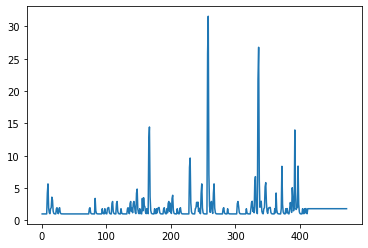

In [0]:
plt.plot(prediction)

In [0]:
model2 = SimpleExpSmoothing(data).fit(smoothing_level=0.2,optimized=False)
prediction = model2.predict(1,472)
print(prediction[412:450])

413    1.526158
414    1.526158
415    1.526158
416    1.526158
417    1.526158
418    1.526158
419    1.526158
420    1.526158
421    1.526158
422    1.526158
423    1.526158
424    1.526158
425    1.526158
426    1.526158
427    1.526158
428    1.526158
429    1.526158
430    1.526158
431    1.526158
432    1.526158
433    1.526158
434    1.526158
435    1.526158
436    1.526158
437    1.526158
438    1.526158
439    1.526158
440    1.526158
441    1.526158
442    1.526158
443    1.526158
444    1.526158
445    1.526158
446    1.526158
447    1.526158
448    1.526158
449    1.526158
450    1.526158
dtype: float64


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


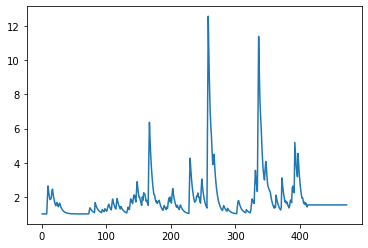

In [0]:
plt.plot(prediction)